# Imports

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import sys
import copy

sys.path.append('/home/nico/VSCodeRepos/SigMA/')
from SigMA.SigMA import SigMA
from miscellaneous.error_sampler import ErrorSampler
from velocity_testing.velocity_test import VelocityTester

# Plotting Function

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#plt_colors = [
#    '#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3',
#    '#FF6692', '#B6E880', '#FF97FF', '#FECB52', '#B82E2E', '#316395'
#]

def plot_3D_data(data, xyz_titles=['X', 'Y', 'Z'], ax_range=[-40, 40], labels=None, true_labels=None):
    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{"type": "scatter3d"}]],
        column_widths=[1],
        subplot_titles=[
            '3D', 
        ],
    )

    # if true labels is not none, get rid of cluster -1
    if true_labels is not None:
        data = data.loc[true_labels != -1]
        # true_labels = true_labels[true_labels != -1]
        labels = labels[true_labels != -1]
    print(np.unique(labels, return_counts=True))

    # --------------- 3D scatter plot -------------------
    if labels is None:
        trace_3d = go.Scatter3d(
            x=data.loc[:, xyz_titles[0]], y=data.loc[:, xyz_titles[1]], z=data.loc[:, xyz_titles[2]],
            mode='markers',
            marker=dict(size=5, color='red'),
            hoverinfo='none',
            showlegend=False,
        )
        fig.add_trace(trace_3d, row=1, col=1)
    else:
        for l_i in np.unique(labels):
            if l_i != -1:
                trace_3d = go.Scatter3d(
                    x=data.loc[labels==l_i, xyz_titles[0]], y=data.loc[labels==l_i, xyz_titles[1]], z=data.loc[labels==l_i, xyz_titles[2]],
                    mode='markers',
                    marker=dict(size=5),
                    hoverinfo='none',
                    showlegend=True,
                    name=f'Cluster {l_i}'
                )
                fig.add_trace(trace_3d, row=1, col=1)
    
    # 3d position
    plt_kwargs = dict(showbackground=False, showline=False, zeroline=True, zerolinecolor='grey', zerolinewidth=2, 
                      showgrid=True, showticklabels=True, color='black',
                      linecolor='black', linewidth=1,  gridcolor='rgba(100,100,100,0.5)')

    xaxis=dict(**plt_kwargs, title=xyz_titles[0], range=ax_range)
    yaxis=dict(**plt_kwargs, title=xyz_titles[1], range=ax_range)
    zaxis=dict(**plt_kwargs, title=xyz_titles[2], range=ax_range)

    # Finalize layout
    fig.update_layout(
        title="",
        #width=800,
        #height=800,
        showlegend=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        legend= dict(itemsizing='constant', font_color='black'),
        # 3D plot
        scene=dict(
            xaxis=dict(xaxis),
            yaxis=dict(yaxis),
            zaxis=dict(zaxis)
        )
    )
    fig.write_html(f"/home/nico/Desktop/evaluation_data/simulated_cluster_{'sigma' if true_labels is not None else 'true'}.html")

# Data Generation

In [9]:
class DataGenerator:
    def __init__(self):
        self.data_gaia = pd.read_csv('simulated_data/data_orion_focus.csv')
        self.df_xyz = pd.read_csv('simulated_data/Simulated_clusters_labeled_Region0_run6.csv')
        self.df_uvw = pd.read_csv('simulated_data/UVW_stats_region0_new.csv')

        self.X_means = self.df_xyz.groupby('label').mean()[['X', 'Y', 'Z']]
        # self.X_means['X_std'] = np.random.uniform(3, 8, size=len(self.X_means))
        # self.X_means['Y_std'] = np.random.uniform(3, 8, size=len(self.X_means))
        # self.X_means['Z_std'] = np.random.uniform(3, 8, size=len(self.X_means))
        self.X_means['X_std'] = [3, 4, 5, 6, 7, 8]
        self.X_means['Y_std'] = [3, 4, 5, 6, 7, 8]
        self.X_means['Z_std'] = [3, 4, 5, 6, 7, 8]

        new_idx = self.df_uvw.columns[1:]
        new_cols = self.df_uvw['Cluster_id new'].values
        self.df_uvw = pd.DataFrame(self.df_uvw[new_idx].T.values, columns=new_cols, index=new_idx).rename(
            columns={'mean U': 'U', 'mean V': 'V', 'mean W': 'W', 
                'SD U': 'U_std', 'SD V': 'V_std', 'SD W': 'W_std'},
        )

        # for the first 6 clusters, add uvw info
        self.df_infos = pd.concat((self.X_means, self.df_uvw.iloc[:6].reset_index(inplace=False, drop=True)), axis=1)
        self.df_infos['U_std'] = 2
        self.df_infos['V_std'] = 2
        self.df_infos['W_std'] = 2

        self.df = None
        self.labels = None

    def generate_data(self, test_cases):
        mu_cols_position = ['X', 'Y', 'Z']
        mu_cols_velocity = ['U', 'V', 'W']
        std_cols = ['U_std', 'V_std', 'W_std']
        data_simulated = []
        self.labels = []

        # generate data for each cluster
        cluster_id = 0
        """ for i in range(self.df_infos.shape[0]):
            mu_position = self.df_infos[mu_cols_position].iloc[i].values # get the means for each cluster, position
            mu_velocity = self.df_infos[mu_cols_velocity].iloc[i].values # get the means for each cluster, velocity
            std = self.df_infos[std_cols].iloc[i].values # get the std for each cluster
            N = max(int(self.df_infos[['n_cluster']].iloc[i].values), 200) // 2 # either 50 or n_cluster
            C = np.diag(std**2) # covariance matrix with variance on diagonal
            # create one cluster with the means of position and velocity, and covariance matrix
            cluster_simulated = [np.random.multivariate_normal(np.concatenate((mu_position, mu_velocity)), C, N)] # generate N samples from multivariate normal
            # add another part of the cluster using shifted position means
            mu_position = mu_position + (np.ones(3) * shift_mean_val[i] * shift_direction[i])
            cluster_simulated.append(np.random.multivariate_normal(np.concatenate((mu_position, mu_velocity)), C, N))
            cluster_simulated = np.vstack(cluster_simulated) # stack all data
            data_simulated.append(cluster_simulated) # generate N samples from multivariate normal
            self.labels.append(np.ones(N * 2, dtype=int)*cluster_id) # add labels
            cluster_id += 1 """

        for test_case in test_cases:
            for labels, mu_position, mu_std in zip(test_case['clusters'], test_case['mu_position'], test_case['mu_std']):
                mu_velocity = self.df_infos[mu_cols_velocity].iloc[labels].values
                std = np.concatenate((mu_std, self.df_infos[std_cols].iloc[labels].values))
                N = max(int(self.df_infos[['n_cluster']].iloc[labels].values), 200)
                C = np.diag(std**2)
                cluster_simulated = np.random.multivariate_normal(np.concatenate((mu_position, mu_velocity)), C, N)
                data_simulated.append(cluster_simulated)
                self.labels.append(np.ones(N, dtype=int)*cluster_id)
                cluster_id += 1
            
        data_simulated = np.vstack(data_simulated) # stack all data
        self.labels = np.hstack(self.labels) # stack all labels

        # Simulate a Gaussian cluster in 6D
        cols = ['X', 'Y', 'Z', 'U', 'V', 'W']
        self.df = pd.DataFrame(data_simulated, columns=cols)

        # Sample from the ErrorSampler
        cols2match = [
            'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'radial_velocity_error',
            'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
            'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr'
        ]
        ra, dec, plx, pmra, pmdec, rv = ErrorSampler().cart2spher(self.df[cols].values)
        self.df['ra'] = ra
        self.df['dec'] = dec
        self.df['parallax'] = plx
        self.df['pmra'] = pmra
        self.df['pmdec'] = pmdec
        self.df['radial_velocity'] = rv

        return self.df, self.labels
        
    def add_noise(self, n_samples=50_000):
        cols = ['X', 'Y', 'Z', 'U', 'V', 'W']
        cols2match = [
            'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'radial_velocity_error',
            'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
            'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr'
        ]
        # Add bg noise
        delta_perc = 50
        ptp_data = self.df[cols].max() - self.df[cols].min()
        ranges = [
            (self.df[col].min() - ptp_data[col] * delta_perc, self.df[col].max() + ptp_data[col] * delta_perc) 
                for col in cols
            ]
        # Create uniform noise
        noise = pd.DataFrame(np.random.uniform(*zip(*ranges), (n_samples, len(cols))), columns=cols)
        ra, dec, plx, pmra, pmdec, rv = ErrorSampler().cart2spher(noise[cols].values)
        noise['ra'] = ra
        noise['dec'] = dec
        noise['parallax'] = plx
        noise['pmra'] = pmra
        noise['pmdec'] = pmdec
        noise['radial_velocity'] = rv
        cols_shere = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity']
        # Add noise to data
        self.df = pd.concat([self.df[cols + cols_shere], noise[cols + cols_shere]], axis=0)
        self.labels = np.r_[self.labels, np.ones(n_samples) * -1].astype(int)

        # Compute distances to cluster centers
        dists = np.sqrt(np.sum(self.X_means.values**2, axis=1))
        dx = 2
        dmin, dmax = dists.min()-dx, dists.max()+dx 
        self.data_gaia['dist'] = np.sqrt(np.sum(self.data_gaia[['X', 'Y', 'Z']].values**2, axis=1))
        self.data_gaia = self.data_gaia.loc[(self.data_gaia['dist'] > dmin) & (self.data_gaia['dist'] < dmax)]

        # Keep only data within cluster range
        self.df[cols2match] = self.data_gaia[cols2match].sample(n=self.df.shape[0], replace=True).values
        self.df.loc[self.df['radial_velocity_error'].isna().values.ravel(), 'radial_velocity_error'] = 1e3

        err_sampler = ErrorSampler(self.df)
        err_sampler.build_covariance_matrix()
        # Create sample from errors
        data_new = pd.DataFrame(err_sampler.new_sample(), columns=cols_shere)
        data_new_cart = pd.DataFrame(err_sampler.spher2cart(data_new.values), columns=cols)
        data = pd.concat([data_new, data_new_cart, self.df[cols2match].reset_index(drop=True)], axis=1)

        return data, self.labels

    def run_error_sampler(self):
        cols = ['X', 'Y', 'Z', 'U', 'V', 'W']
        err_sampler = ErrorSampler(self.df)
        err_sampler.build_covariance_matrix()
        # Create sample from errors
        data_new = pd.DataFrame(err_sampler.spher2cart(err_sampler.new_sample()), columns=cols)

        return data_new, self.labels

# Plotting True

In [11]:
# contains true split
test_case_1 = [
    {
        'clusters': [0, 1],
        'mu_position': [
            [-500, -500, 20],
            [-490, -490, 30]
        ],
        'mu_std': [
            np.array([3, 5, 2]),
            np.array([4, 8, 2])
        ]
    }
]

# contains true split
test_case_2 = [
    {
        'clusters': [0, 2],
        'mu_position': [
            [20, 40, 150],
            [20, 40, 150]
        ],
        'mu_std': [
            np.array([7, 3, 4]),
            np.array([6, 5, 5])
        ]
    }
]

# contains true split
test_case_3 = [
    {
        'clusters': [0, 3],
        'mu_position': [
            [-20, 40, 160],
            [-20, 40, 140]
        ],
        'mu_std': [
            np.array([5, 7, 3]),
            np.array([4, 5, 3])
        ]
    }
]

# contains true split
test_case_4 = [
    {
        'clusters': [0, 4],
        'mu_position': [
            [-20, 300, 160],
            [-20, 300, 150]
        ],
        'mu_std': [
            np.array([4, 3, 4]),
            np.array([6, 5, 4])
        ]
    }
]

# contains true split
test_case_5 = [
    {
        'clusters': [0, 5],
        'mu_position': [
            [-20, 300, 170],
            [-20, 300, 160]
        ],
        'mu_std': [
            np.array([4, 3, 4]),
            np.array([6, 5, 4])
        ]
    }
]

# contains a few noise splits
test_case_6 = [
    {
        'clusters': [1, 2],
        'mu_position': [
            [-30, -150, 180],
            [-30, -150, 160]
        ],
        'mu_std': [
            np.array([4, 2, 4]),
            np.array([6, 6, 4])
        ]
    }
]

# contains a true split
test_case_7 = [
    {
        'clusters': [1, 3],
        'mu_position': [
            [-30, 150, 180],
            [-30, 150, 160]
        ],
        'mu_std': [
            np.array([5, 7, 7]),
            np.array([4, 4, 7])
        ]
    }
]

# contains a true split
test_case_8 = [
    {
        'clusters': [1, 4],
        'mu_position': [
            [200, -150, 0],
            [200, -170, 0]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([7, 7, 7])
        ]
    }
]

# contains a true split
test_case_9 = [
    {
        'clusters': [1, 5],
        'mu_position': [
            [100, 200, -150],
            [100, 200, -150]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([7, 7, 7])
        ]
    }
]

# contains a true split
test_case_10 = [
    {
        'clusters': [2, 3],
        'mu_position': [
            [-100, 200, -150],
            [-100, 200, -150]
        ],
        'mu_std': [
            np.array([4, 4, 3]),
            np.array([7, 5, 7])
        ]
    }
]

# contains a true split and 2 noise splits
test_case_11 = [
    {
        'clusters': [2, 4],
        'mu_position': [
            [-100, 300, -150],
            [-100, 300, -150]
        ],
        'mu_std': [
            np.array([7, 7, 7]),
            np.array([7, 7, 7])
        ]
    }
]

# contains 5 noise spilts
test_case_12 = [
    {
        'clusters': [2, 5],
        'mu_position': [
            [-100, 400, -150],
            [-100, 400, -150]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([3, 3, 3])
        ]
    }
]

# contains a few noise splits
test_case_13 = [
    {
        'clusters': [3, 4],
        'mu_position': [
            [270, 200, 300],
            [270, 200, 300]
        ],
        'mu_std': [
            np.array([4, 3, 7]),
            np.array([4, 5, 5])
        ]
    }
]

# contains a few noise splits
test_case_14 = [
    {
        'clusters': [3, 5],
        'mu_position': [
            [260, -100, 200],
            [260, -100, 200]
        ],
        'mu_std': [
            np.array([4, 3, 7]),
            np.array([4, 5, 6])
        ]
    }
]

# can contain a wrong split
test_case_15 = [
    {
        'clusters': [0, 0],
        'mu_position': [
            [260, -90, 200],
            [260, -115, 200]
        ],
        'mu_std': [
            np.array([4, 3, 7]),
            np.array([4, 5, 6])
        ]
    }
]

# can contain a wrong split
test_case_16 = [
    {
        'clusters': [1, 1],
        'mu_position': [
            [120, 20, 200],
            [120, -10, 200]
        ],
        'mu_std': [
            np.array([5, 7, 7]),
            np.array([4, 7, 7])
        ]   
    }
]

# can contain a wrong split
test_case_17 = [
    {
        'clusters': [2, 2],
        'mu_position': [
            [400, 400, 400],
            [360, 400, 400]
        ],
        'mu_std': [
            np.array([7, 7, 4]),
            np.array([7, 7, 4])
        ]   
    }
]

# can contain a wrong split
test_case_18 = [
    {
        'clusters': [3, 3],
        'mu_position': [
            [400, 250, 400],
            [400, 265, 400]
        ],
        'mu_std': [
            np.array([3, 3, 3]),
            np.array([3, 3, 3])
        ]   
    }
]

# can contain a wrong split
test_case_19 = [
    {
        'clusters': [4, 4],
        'mu_position': [
            [-100, 250, 400],
            [-127, 250, 400]
        ],
        'mu_std': [
            np.array([4, 6, 7]),
            np.array([4, 2, 5])
        ]   
    }
]

# can contain a wrong split
test_case_20 = [
    {
        'clusters': [5, 5],
        'mu_position': [
            [200, -350, 150],
            [230, -350, 150]
        ],
        'mu_std': [
            np.array([7, 5, 4]),
            np.array([3, 3, 5])
        ]   
    }
]

# total about:
# - 10 true splits
# - 10 noise splits
# - 5 wrong splits

# combine the test cases
test_cases = test_case_1 + test_case_2 + test_case_3 + test_case_4 + test_case_5 + test_case_6 + test_case_7 + test_case_8 + test_case_9 + test_case_10 + test_case_11 + test_case_12 + test_case_13 + test_case_14 + test_case_15 + test_case_16 + test_case_17 + test_case_18 + test_case_19 + test_case_20

data_generator = DataGenerator()
data_generator.generate_data(test_case_1)
data, labels_true = data_generator.add_noise(n_samples=50000)

In [2]:
cols = ['X', 'Y', 'Z']
# cols = ['ra', 'dec', 'parallax']
# cols = ['U', 'V', 'W']
# cols = ['pmra', 'pmdec', 'radial_velocity']
plot_3D_data(data, xyz_titles=cols, ax_range=[-1000, 1000], labels=labels_true, true_labels=None)

NameError: name 'plot_3D_data' is not defined

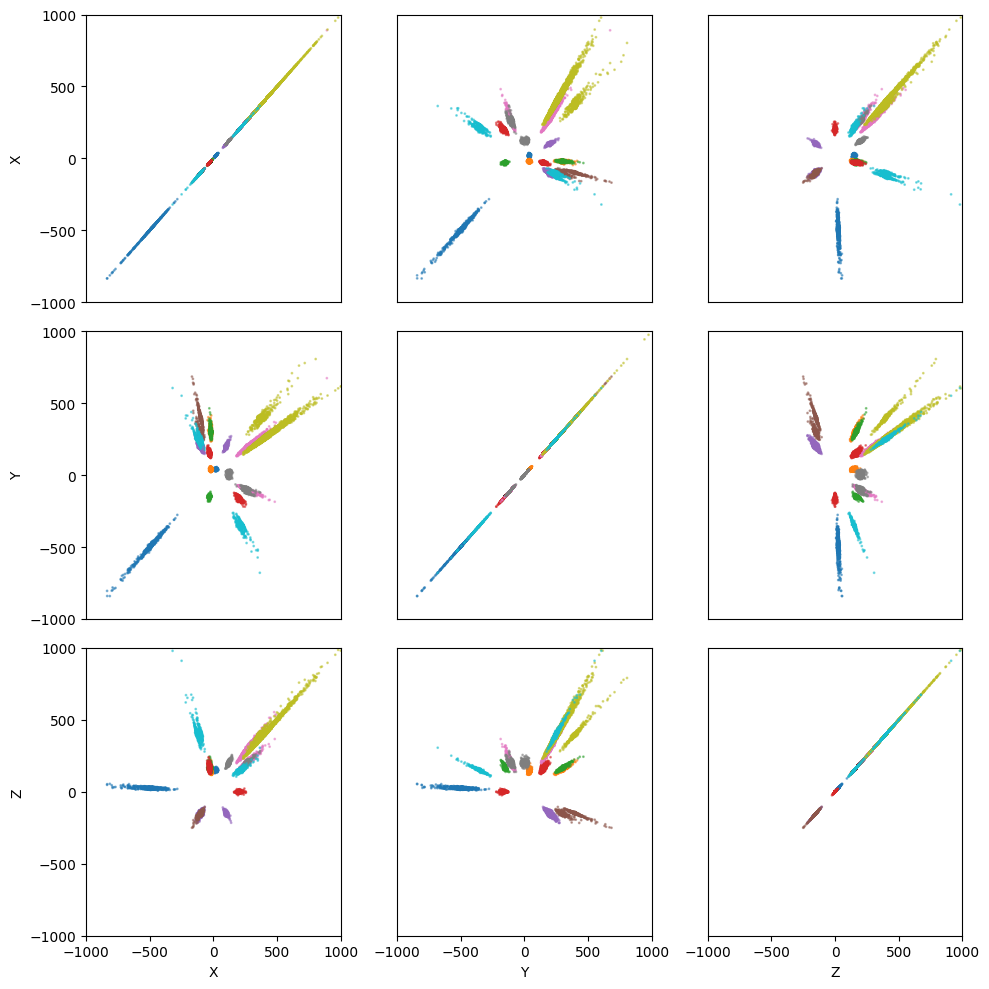

In [355]:
import matplotlib.pyplot as plt

data_no_noise = copy.deepcopy(data)
data_no_noise = data_no_noise[labels_true != -1]
labels_true_no_noise = copy.deepcopy(labels_true)
labels_true_no_noise = labels_true_no_noise[labels_true != -1]

# create a scatterplot matrix in matplotlib
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        axes[i, j].scatter(data_no_noise[cols[j]], data_no_noise[cols[i]], s=1, c=labels_true_no_noise, cmap='tab10', alpha=0.5)

        axes[i, j].set_xlim(-1000, 1000)
        axes[i, j].set_ylim(-1000, 1000)
        # get rid of right and top spines
        # only show ticks on the most left and bottom axes
        if i == 2:
            axes[i, j].set_xlabel(cols[j])
            axes[i, j].set_xticks([-1000, -500, 0, 500, 1000])
        else:
            axes[i, j].set_xticks([])
        if j == 0:
            axes[i, j].set_ylabel(cols[i])
            axes[i, j].set_yticks([-1000, -500, 0, 500, 1000])
        else:
            axes[i, j].set_yticks([])
# fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
plt.show()

# Plotting SigMA

In [318]:
cols2fit = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
df_fit = copy.deepcopy(data[cols2fit])
# Scale features
sf = {
    'ra': 1/0.64,
    'dec': 1/0.65,
    'parallax': 1/0.15,
    'pmra': 1/0.49,
    'pmdec': 1/0.57
}
for col in cols2fit:
    df_fit[col] *= sf[col]

sigma_kwargs = dict(
    cluster_features=cols2fit,
    scale_factors=None,
    # These are the default values and should be kept for now
    nb_resampling=0, max_knn_density=101,
    beta=0.99, knn_initcluster_graph=40,
    transform_function=None
)
clusterer = SigMA(data=df_fit, **sigma_kwargs).fit(alpha=0.01, knn=15, bh_correction=True)

Performing gradient ascend using a 15-NN density estimation.
Updated significance threshold: 2.93e-04


In [319]:
plot_3D_data(data, xyz_titles=cols, ax_range=[-1000, 1000], labels=clusterer.labels_, true_labels=labels_true)
# plot_3D_data(data, xyz_titles=cols, ax_range=[-1000, 1000], labels=clusterer.labels_, true_labels=None)

(array([  439,   915,  1194,  1518,  1970,  5681,  6009,  6442,  7035,
        7053, 11127, 11885, 12412, 12795, 13410, 17343, 17738, 17849,
       18469, 23039, 26290, 27676, 27997, 28204, 33392, 36385, 36567,
       36810, 37096]), array([ 743,  305,  198,  277, 3995,  616,  269,  199,  439,  199, 4403,
        712,  438,  200, 4171,  467,  201,  200, 4240, 4576,  199,  876,
        206,  194, 7929,  259,  289,  189,  211]))


In [320]:
def produce_baseline(clusterer):
    _, p_values = clusterer.run_sigma(
        alpha=-np.inf, knn=15, return_pvalues=True
    )
    p_values = np.array(p_values)
    pv_sorted = np.sort(p_values[p_values < 0.05])
    # compute mid point betw*een consecutive p-values
    mid_points = (pv_sorted[1:] + pv_sorted[:-1]) / 2
    return mid_points, clusterer.labels_

mid_points, l0 = produce_baseline(clusterer)

In [321]:
splits = {}
clusterer_labels = pd.DataFrame({f'iteration_0': l0})
print(f'iteration count: {len(mid_points)}')
iteration = 1
for alpha_i in mid_points:
    # fit clusterer to new alpha
    clusterer = clusterer.fit(alpha=alpha_i, knn=15, bh_correction=False)
    print(f'iteration {iteration}')

    l_i = clusterer.labels_
    new_clusters_id = list(set(l_i) - set(l0))
    clusterer_labels[f'iteration_{iteration}'] = l_i

    if len(new_clusters_id) == 1: 
        # one new cluster was generated
        nc_id = new_clusters_id[0]
        part_of_old_cluster = mode(l0[l_i==nc_id], keepdims=False).mode
        print(f'New cluster: {nc_id} coming from {part_of_old_cluster}')
        splits[f'iteration_{iteration}'] = {
            'new_cluster': nc_id,
            'old_cluster': part_of_old_cluster,
            'alpha': alpha_i
        }

        # print the true labels of the new cluster
        print(f'True labels new cluster: {np.unique(labels_true[l_i==nc_id], return_counts=True)}')
        print(f'True labels old cluster: {np.unique(labels_true[l_i==part_of_old_cluster], return_counts=True)}')
        
    elif len(new_clusters_id) > 1:
        print('More than one new cluster')
    else:
        print('No new cluster')

    iteration += 1
    l0 = np.copy(l_i)
    print('-------------------\n')

iteration count: 57
iteration 1
No new cluster
-------------------

iteration 2
No new cluster
-------------------

iteration 3
No new cluster
-------------------

iteration 4
No new cluster
-------------------

iteration 5
No new cluster
-------------------

iteration 6
No new cluster
-------------------

iteration 7
No new cluster
-------------------

iteration 8
No new cluster
-------------------

iteration 9
No new cluster
-------------------

iteration 10
No new cluster
-------------------

iteration 11
No new cluster
-------------------

iteration 12
No new cluster
-------------------

iteration 13
No new cluster
-------------------

iteration 14
No new cluster
-------------------

iteration 15
No new cluster
-------------------

iteration 16
No new cluster
-------------------

iteration 17
No new cluster
-------------------

iteration 18
No new cluster
-------------------

iteration 19
No new cluster
-------------------

iteration 20
No new cluster
-------------------

iteration

In [182]:
import matplotlib.pyplot as plt

def dense_sample(rho):
    """Extract the densest points from the density distribution."""
    mad = np.median(np.abs(rho - np.median(rho)))
    threshold = np.median(rho) * 0.995 + 3 * mad * 1.1
    if np.sum(rho > threshold) < 20:
        threshold = np.percentile(rho, 93)
    return rho > threshold

# plotting the clustered labels according to their true cluster
for split in splits:
    old_cluster = splits[split]['old_cluster']
    new_cluster = splits[split]['new_cluster']

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for i, cluster in enumerate([old_cluster, new_cluster]):
        # get the dense core
        rho = clusterer.weights_[clusterer_labels[split] == cluster]
        dense_core = dense_sample(rho)
        # plot the dense core
        label, counts = np.unique(labels_true[clusterer_labels[split] == cluster][dense_core], return_counts=True)
        ax[i].bar(label, counts)

    plt.close()
    fig.savefig(f'/home/nico/Desktop/split_{split}.png')

In [66]:
cols = ['X', 'Y', 'Z']
# cols = ['ra', 'dec', 'plx']
# cols = ['U', 'V', 'W']
# cols = ['pmra', 'pmdec', 'radial_velocity']
plot_3D_data(df, xyz_titles=cols, ax_range=[-600, 600], labels=clusterer.labels_, true_labels=labels_true)

(array([   12,   720,  3110,  4054,  5105,  5345,  5610,  5763,  6081,
        6156,  7979,  9011, 10026, 10450, 10572, 10712, 10786, 10948,
       11108, 11304, 11518, 12430, 15769, 15900, 16005, 16046]), array([ 390,  212, 2188, 2427,   83,   80,  108,  363,  224,   58,  121,
        395, 3787,  124,   72,  128,  168,  161,  212,  202,  197, 3970,
        128,  130,  114,   98]))
